In [1]:
#Importing libraries
import cv2
import numpy as np
from skimage import exposure, feature
from sklearn import svm
from sklearn import metrics
import os

In [2]:
# To extract HOG features from an image
def hog_feature_extraction(image):
    hog_features = feature.hog(image, orientations=10, pixels_per_cell=(8, 8),
                               cells_per_block=(2,2), transform_sqrt=True, block_norm="L2-Hys")
    return hog_features

In [3]:
# Resizing image to target size
def resize_image(image, target_size=(128, 128)):
    resized_image = cv2.resize(image, target_size)
    return resized_image

In [4]:
# Loading and processing images
def load_and_process_images(dataset_path, label):
    hog_features = []
    labels = []

    for filename in os.listdir(dataset_path):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            image_path = os.path.join(dataset_path, filename)
            original_image = cv2.imread(image_path)

            # Converting to BGR to grayscale
            resized_image = resize_image(original_image, target_size=(128, 128))
            gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
            # Extracting HOG features
            features = hog_feature_extraction(gray_image)

            # Appending  HOG features and label to the lists
            hog_features.append(features)
            labels.append(label)

    return np.array(hog_features), np.array(labels)

# Loading and processing positive and negative images
X_pos_train, y_pos_train = load_and_process_images('/kaggle/input/emotion-detection-fer/train/angry', 1)
X_neg_train, y_neg_train = load_and_process_images('/kaggle/input/emotion-detection-fer/train/neutral', 0)


In [5]:
# Concatenating the features and labels from both training images
X_train = np.concatenate((X_pos_train, X_neg_train))
y_train = np.concatenate((y_pos_train, y_neg_train))

In [6]:
from sklearn.decomposition import PCA
X_train_reshaped = np.reshape(X_train, (len(X_train), -1))
# Applying PCA for dimensionality reduction
n_components = 100 
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_reshaped)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn import metrics



# Splitting data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshaping the training features
X_train_reshaped = np.reshape(X_train_split, (len(X_train_split), -1))

# Applying PCA transformation to training features
X_train_pca = pca.transform(X_train_reshaped)

# SVM classifier
svm_classifier = svm.SVC(kernel='linear', C=0.1)

# Fitting the classifier with the transformed training features
svm_classifier.fit(X_train_pca, y_train_split)

# Reshaping features
X_val_reshaped = np.reshape(X_val_split, (len(X_val_split), -1))

# Applying PCA transformation to validation features
X_val_pca = pca.transform(X_val_reshaped)

# Make predictions on the validation set
val_predictions = svm_classifier.predict(X_val_pca)

# Evaluate the model on the validation set
val_accuracy = metrics.accuracy_score(y_val_split, val_predictions)
val_confusion_matrix = metrics.confusion_matrix(y_val_split, val_predictions)

print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')
print('Validation Confusion Matrix:')
print(val_confusion_matrix)


Validation Accuracy: 69.75%
Validation Confusion Matrix:
[[796 207]
 [335 454]]


In [8]:
# Test images
testing_dir = '/kaggle/input/emotion-detection-fer/test/angry'

# Image files in the testing directory
testing_paths = [os.path.join(testing_dir, filename) for filename in os.listdir(testing_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]
num_neutral_testing_samples = len(testing_paths)
y_true = [1] * num_neutral_testing_samples # True labels for the testing images (0 or 1)

resized_images = [resize_image(cv2.imread(path), target_size=(128, 128)) for path in testing_paths]

# Extracting HOG features from the testing images
X_test = [hog_feature_extraction(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)) for image in resized_images]

X_test_reshaped = np.reshape(X_test, (len(X_test), -1))

# Applying PCA transformation to testing features
X_test_pca = pca.transform(X_test_reshaped)

# Predictions on the testing set
predictions = svm_classifier.predict(X_test_pca)

# Evaluating the model
accuracy = metrics.accuracy_score(y_true, predictions)
confusion_matrix = metrics.confusion_matrix(y_true, predictions)


In [9]:
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion_matrix)

Accuracy: 0.592901878914405
Confusion Matrix:
[[  0   0]
 [390 568]]


In [10]:

#positive and negative label
import matplotlib.pyplot as plt
def display_image_with_hog(original_image, resized_image, hog_features):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.set_title("Original Image")
    ax1.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    ax1.axis('off')

    ax2.set_title("Resized Image with HOG Features")
    ax2.imshow(resized_image, cmap=plt.cm.gray)
    ax2.axis('off')


    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.set_title("HOG Features")
    ax.plot(hog_features)
    ax.set_xlabel("Feature Index")
    ax.set_ylabel("HOG Value")

    plt.show()
    


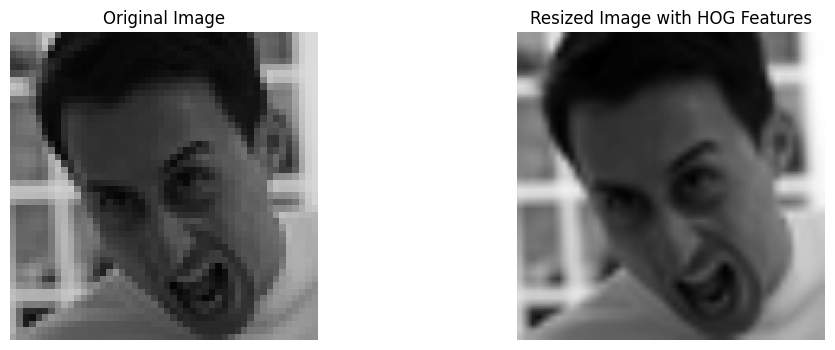

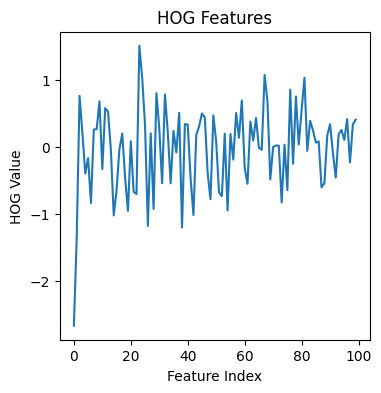

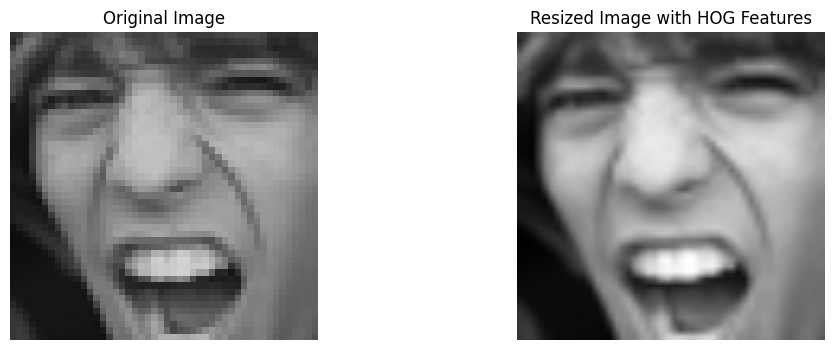

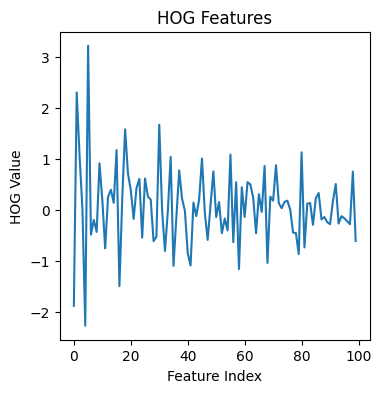

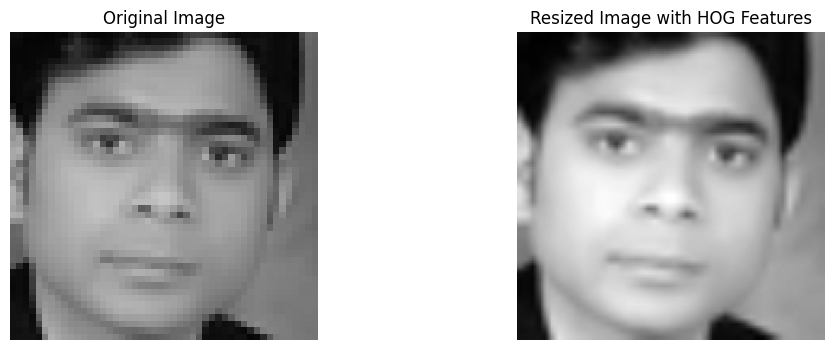

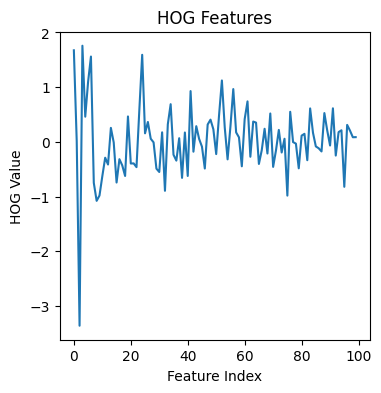

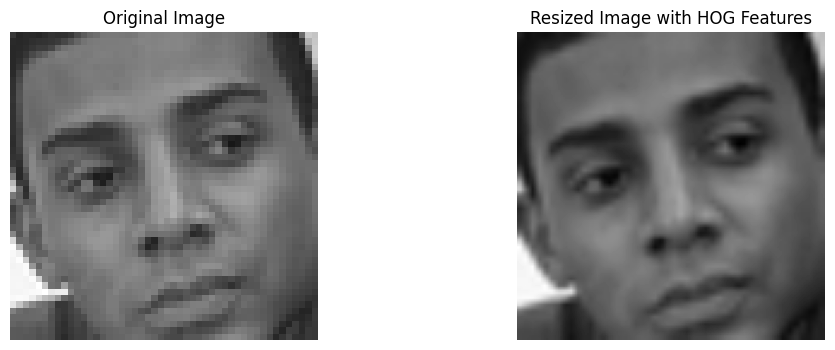

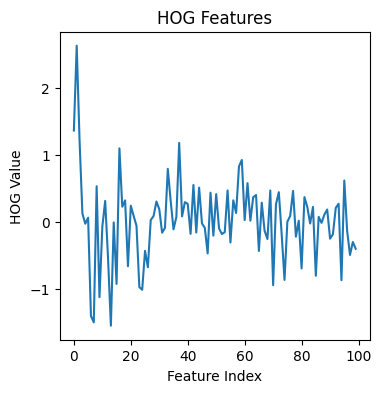

In [11]:
import cv2

# individual images
image_paths = ['/kaggle/input/rand-test/to_test/angry_2.png',
               '/kaggle/input/rand-test/to_test/angry_3.png',
               '/kaggle/input/rand-test/to_test/neutral_1.png',
               '/kaggle/input/rand-test/to_test/neutral_3.png']

# Processing each image separately to visualize hog features
for path in image_paths:
    original_image = cv2.imread(path)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    
    # Resize the image
    resized_image = resize_image(gray_image, target_size=(128, 128))
    
    # Extract HOG features
    hog_features = hog_feature_extraction(resized_image)  # Replace with your HOG function
    hog_features_reshaped = np.reshape(hog_features, (1, -1))
    hog_features_pca = pca.transform(hog_features_reshaped)

    
    # Display the images and HOG features separately
    display_image_with_hog(original_image,resized_image,hog_features_pca[0])


multilabel